(Add description)

## Import dependencies

In [1]:
import warnings
warnings.filterwarnings('ignore')
import sys
import pathlib
current_path = pathlib.Path().absolute()
root_path = "{0}/..".format(current_path)
sys.path.append("{0}/src".format(root_path))

import numpy as np
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD, Adam

import backbones
import utils.plots as plots
from train_engine import TrainEngine
from utils import load_dataset, ImageGeneratorConfig, setup_environment

In [2]:
setup_environment(enable_gpu=True)

## Prepare training and evaluation

As we have only few images, we need to augment them to get more input for our neuronal network.

In [3]:
train_files_path = "{0}/img/space_ships/train".format(root_path)
eval_files_path = "{0}/img/space_ships/eval".format(root_path)

input_shape = (138, 256, 3)
generator_config = ImageGeneratorConfig()
generator_config.loop_count = 10
generator_config.horizontal_flip = True
generator_config.zoom_range = 0.5
generator_config.width_shift_range = 0.03
generator_config.height_shift_range = 0.03
generator_config.rotation_range = 180

#generator_config = None

train_x, train_y, eval_x, eval_y = load_dataset(
    train_files_path, input_shape, validation_split=0.1
)

print(train_y)

Using class indexes as train_y
Split dataset into 18 train and 3 test data
[1. 1. 0. 2. 0. 0. 0. 1. 2. 2. 2. 1. 0. 0. 1. 0. 1. 2.]


## Create model

In [4]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

base_model = Xception(include_top=False, weights='imagenet', input_shape=input_shape)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(3, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=x)

optimizer = Adam(lr=0.001)

## Create train engine

First we will train the model the new classes.

In [5]:
for layer in base_model.layers:
    layer.trainable = False
    
train_engine = TrainEngine(
    input_shape, 
    model, 
    optimizer, 
    loss="sparse_categorical_crossentropy"
)

## Train model

In [6]:
loss, acc, val_loss, val_acc = train_engine.train(
    train_x,
    train_y,
    eval_x,
    eval_y,
    epochs=50,
    batch_size=32,
    image_generator_config=generator_config,
    is_augment_y_enabled=False,
    is_classification=True
)

Epoch 10/50	loss: 0.22376	acc: 0.91	val_loss: 0.11615	val_acc: 0.96667
Epoch 20/50	loss: 0.14381	acc: 0.94528	val_loss: 0.06016	val_acc: 0.98333
Epoch 30/50	loss: 0.11605	acc: 0.95611	val_loss: 0.0486	val_acc: 0.97778
Epoch 40/50	loss: 0.09775	acc: 0.96333	val_loss: 0.03647	val_acc: 0.98333
Epoch 50/50	loss: 0.08484	acc: 0.96867	val_loss: 0.02918	val_acc: 0.98667


Now we fine tune the convolutional layers from the base model.

In [7]:
for layer in base_model.layers[:249]:
    layer.trainable = False
for layer in model.layers[249:]:
    layer.trainable = True
    
optimizer = SGD(lr=0.0001, momentum=0.9)

train_engine = TrainEngine(
    input_shape, 
    model, 
    optimizer, 
    loss="sparse_categorical_crossentropy"
)

In [8]:
loss, acc, val_loss, val_acc = train_engine.train(
    train_x,
    train_y,
    eval_x,
    eval_y,
    epochs=150,
    batch_size=32,
    image_generator_config=generator_config,
    is_augment_y_enabled=False,
    is_classification=True
)

Epoch 10/150	loss: 0.02327	acc: 0.99222	val_loss: 0.0	val_acc: 1.0
Epoch 20/150	loss: 0.04689	acc: 0.98528	val_loss: 0.0	val_acc: 1.0
Epoch 30/150	loss: 0.03749	acc: 0.98815	val_loss: 0.0	val_acc: 1.0
Epoch 40/150	loss: 0.03241	acc: 0.98972	val_loss: 0.0	val_acc: 1.0
Epoch 50/150	loss: 0.02626	acc: 0.99178	val_loss: 0.0	val_acc: 1.0
Epoch 60/150	loss: 0.03907	acc: 0.98778	val_loss: 0.0	val_acc: 1.0
Epoch 70/150	loss: 0.04169	acc: 0.98675	val_loss: 0.0	val_acc: 1.0
Epoch 80/150	loss: 0.04271	acc: 0.98639	val_loss: 0.0	val_acc: 1.0
Epoch 90/150	loss: 0.04375	acc: 0.98623	val_loss: 0.0	val_acc: 1.0
Epoch 100/150	loss: 0.04529	acc: 0.98511	val_loss: 0.0	val_acc: 1.0
Epoch 110/150	loss: 0.0456	acc: 0.985	val_loss: 0.0	val_acc: 1.0
Epoch 120/150	loss: 0.04908	acc: 0.98435	val_loss: 0.0	val_acc: 1.0
Epoch 130/150	loss: 0.04914	acc: 0.9844	val_loss: 0.0	val_acc: 1.0
Epoch 140/150	loss: 0.05306	acc: 0.98345	val_loss: 0.0	val_acc: 1.0
Epoch 150/150	loss: 0.05848	acc: 0.98196	val_loss: 0.0	val_ac

## Show history

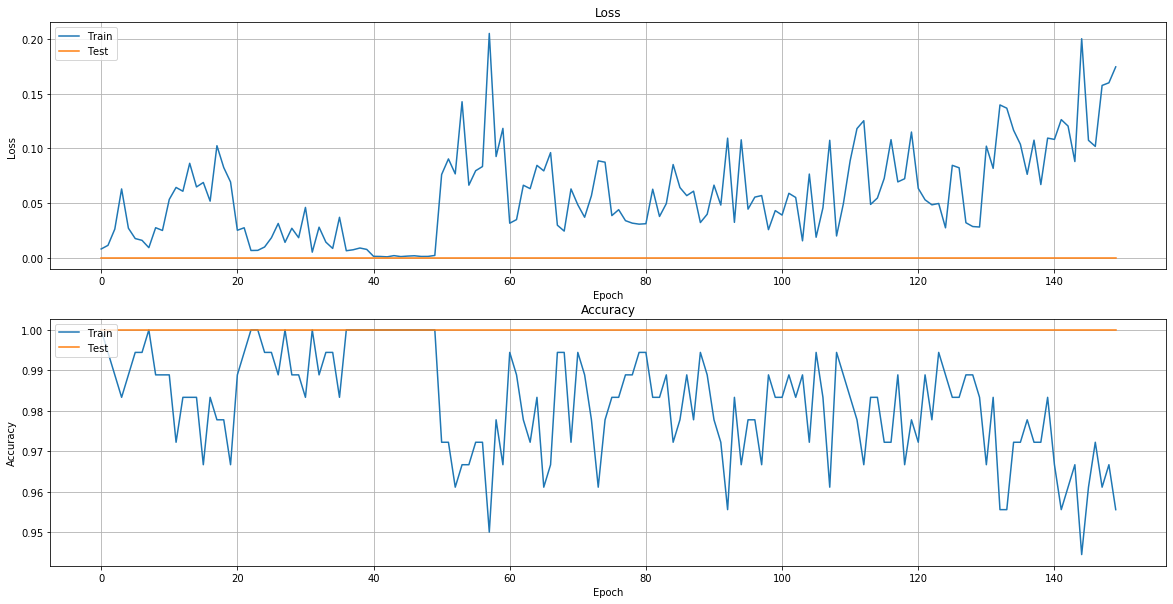

In [9]:
plots.plot_history(loss, acc, val_loss, val_acc)

## Predict

### Eval dataset we used while training

In [10]:
x, _, _, _ = load_dataset(
    eval_files_path, input_shape, validation_split=0
) 

for idx in range(len(x[:5])):
    predictions = train_engine.model.predict(
        np.array([x[idx]], dtype=np.float32), batch_size=1
    )
    plots.plot_difference(predictions, [x[idx]], input_shape)

No classes detected, will continue without classes!
Using train_x as train_y


ValueError: cannot reshape array of size 3 into shape (138,256,3)

<Figure size 1440x720 with 0 Axes>

As we can see, the bad parts have a much higher squared error (SE) as the good one.
Our training images didn't contain any rotated sample, but the network could still easily reconstruct it with a small error rate.

## Cleanup

In [ ]:
K.clear_session()